In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.metrics import f1_score, roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm
from sklearn.decomposition import PCA

from contextlib import contextmanager
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [0]:
def read_df():
    df_train = pd.read_csv('/content/drive/My Drive/fraud_detection/training.csv')
    df_test = pd.read_csv('/content/drive/My Drive/fraud_detection/test.csv')
    #df_train.loc[df_train['bank_account'] == 'Yes', 'bank_account'] = 1
    #df_train.loc[df_train['bank_account'] == 'No', 'bank_account'] = 0
    return df_train, df_test
df_train, df_test = read_df()

In [293]:
df_train,df_test=read_df()
df_train

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0


In [294]:
df_train.describe(include="all")

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
count,95662,95662,95662,95662,95662,95662,95662.0,95662,95662,95662,95662,9.566200e+04,9.566200e+04,95662,95662.000000,95662.000000
unique,95662,94809,3633,3627,3742,1,NaN,6,23,9,4,NaN,NaN,94556,NaN,NaN
top,TransactionId_109796,BatchId_67019,AccountId_4841,SubscriptionId_3829,CustomerId_7343,UGX,NaN,ProviderId_4,ProductId_6,financial_services,ChannelId_3,NaN,NaN,2018-12-24T16:30:13Z,NaN,NaN
freq,1,28,30893,32630,4091,95662,NaN,38189,32635,45405,56935,NaN,NaN,17,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,6.717846e+03,9.900584e+03,NaN,2.255974,0.002018
std,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.233068e+05,1.231221e+05,NaN,0.732924,0.044872
min,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,-1.000000e+06,2.000000e+00,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,-5.000000e+01,2.750000e+02,NaN,2.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,1.000000e+03,1.000000e+03,NaN,2.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,2.800000e+03,5.000000e+03,NaN,2.000000,0.000000


0    95469
1      193
Name: FraudResult, dtype: int64

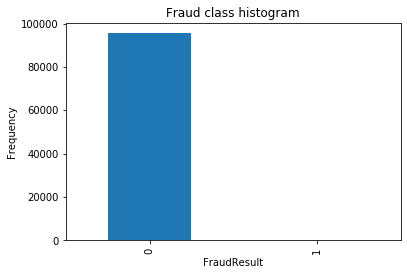

In [295]:
#Histogram to check the distribution of fraud vs non-fraud with inbalanced data :
pd.value_counts(df_train['FraudResult']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('FraudResult')
plt.ylabel('Frequency')
df_train['FraudResult'].value_counts()

In [0]:
def feature_engineering(df):
    #df['countryid'] = df['country']
    df['f1'] = df.groupby(['ProductCategory'])['Amount'].transform('count')
    #df['f2'] = df.groupby(['ProductCategory'])['Amount'].transform('mean') 
    #df['f3'] = df.groupby(['ProductCategory','FraudResult'])['FraudResult'].transform('count')
    #df['f4'] = df.groupby(columns)['age_of_respondent'].transform('count')
    #df['f5'] = df['age_of_respondent'] / df.groupby('household_size')['age_of_respondent'].transform('mean')
    #df['f4'] = df.groupby(['age_of_respondent', 'education_level'])['education_level'].transform('count')
    #df['f4'] = df.groupby(['household_size'])['household_size'].transform('std')
    #df['f5'] = df.groupby(['age_of_respondent'])['education_level'].transform('count')
    
    #df['f5'] = df.groupby(['job_type'])['job_type'].transform('count') 
    #df['f6'] = df.groupby(['job_type'])['age_of_respondent'].transform('mean') 
    #df['f7'] = df.groupby(['location_type'])['location_type'].transform('count')
    #df['f5'] = df.groupby(['household_size'])['household_size'].transform('count') 
    #df['f6'] = (df['household_size'] - df.groupby(['age_of_respondent'])['household_size'].transform('mean') )/\
    #    df.groupby(['age_of_respondent'])['household_size'].transform('std')     
    return df



In [0]:
def search_categorical_col(X):
  categorical_feat = X.dtypes==object 
  categorical_cols = X.columns[categorical_feat].tolist()
  return categorical_cols


In [298]:
categorical_col=search_categorical_col(df_train)
categorical_col

['TransactionId',
 'BatchId',
 'AccountId',
 'SubscriptionId',
 'CustomerId',
 'CurrencyCode',
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'TransactionStartTime']

In [0]:
df_train, df_test = read_df()
df_train = feature_engineering(df_train)    


In [300]:
df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,f1
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,45027
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,45405
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,45027
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,1920
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,45405


In [0]:
def encoding(df, list_cols):
    for col in list_cols:
        lbl = LabelEncoder()
        lbl.fit(list(df[col].values))
        df[col] = lbl.transform(list(df[col].values))      
        #df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=(str(col)))
        #df = pd.concat([df, df_dummies], axis=1)
        
    return df

In [302]:
df_train = encoding(df_train, categorical_col)
df_train


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,f1
0,78150,46980,2490,3535,2584,0,256,5,1,0,2,1000.0,1000,0,2,0,45027
1,75821,31755,3219,2366,2584,0,256,3,19,2,1,-20.0,20,1,2,0,45405
2,39888,60272,2713,996,2806,0,256,5,0,0,2,500.0,500,2,2,0,45027
3,48738,1797,3351,974,3733,0,256,0,11,8,2,20000.0,21800,3,2,0,1920
4,41364,48941,3219,2366,3733,0,256,3,19,2,1,-644.0,644,4,2,0,45405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,88055,92361,3219,2366,1504,0,256,3,19,2,1,-1000.0,1000,94551,2,0,45405
95658,89318,46175,2055,1349,2154,0,256,5,1,0,2,1000.0,1000,94552,2,0,45027
95659,82370,13891,3219,2366,2154,0,256,3,19,2,1,-20.0,20,94553,2,0,45405
95660,27556,73014,296,3344,521,0,256,5,8,7,2,3000.0,3000,94554,2,0,1279


In [0]:
def cross_validation(df): 
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    train_x = df.drop('FraudResult', axis=1)
    train_y = df['FraudResult']
    score = []
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
        
        trn_x, trn_y = train_x.iloc[trn_idx], train_y.iloc[trn_idx]
        val_x, val_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
        
        clf = LGBMClassifier()

        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=250, early_stopping_rounds=150,
               )
        score.append(clf.best_score_['valid_1']['auc'])
        #lightgbm.plot_importance(clf, height=1.0, max_num_features=10)    

        del clf, trn_x, trn_y, val_x, val_y   
    
    return score

In [0]:
def encoding_with_dummies(df, list_cols):
    for col in list_cols:
        lbl = LabelEncoder()
        lbl.fit(list(df[col].values))
        df[col] = lbl.transform(list(df[col].values))      
        df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        
    return df

In [0]:
def SMOTE(df):
    from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
    train_x = df.drop('FraudResult', axis=1)
    train_y = df['FraudResult']
    sm = SMOTE(random_state=0)
    X_res, y_res = sm.fit_resample(train_x, train_y)
    x_smote=pd.DataFrame(X_res,columns=train_x.columns)
    y_smote=pd.DataFrame(y_res,columns=['FraudResult'])
    smote_data=x_smote
    smote_data['FraudResult']=y_smote['FraudResult']
    
    return smote_data

In [0]:
def train(df):
    train_x = df.drop('FraudResult', axis=1)
    train_y = df['FraudResult']     
    train_x, val_x, train_y, val_y =\
    train_test_split(train_x, train_y, stratify=train_y, test_size=0.2, random_state=0)   
    clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=123,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=15,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )

    clf.fit(train_x, train_y,eval_set= [(train_x, train_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150,
            )
        
    
    return clf,train_x, val_x, train_y, val_y

In [307]:
dum_col=['ProductCategory']
df_train=encoding_with_dummies(df_train,dum_col)
df_train
df_test

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14T23:56:28Z,2
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14T23:57:38Z,1
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-14T23:59:17Z,1
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14T23:59:39Z,2


In [0]:
df_train, df_test = read_df()
col1=df_test['TransactionId']
df_train = feature_engineering(df_train)    
df_test = feature_engineering(df_test)
df_train = encoding(df_train, categorical_col)
df_test = encoding(df_test, categorical_col)
df_train=encoding_with_dummies(df_train,dum_col)
df_test=encoding_with_dummies(df_test,dum_col)

df_train=SMOTE(df_train)



0    95469
1      193
Name: FraudResult, dtype: int64

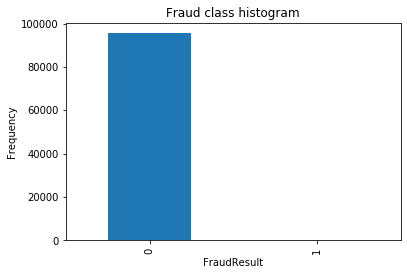

In [309]:
#Histogram to check the distribution of fraud vs non-fraud after balancing the data :
pd.value_counts(df_train['FraudResult']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('FraudResult')
plt.ylabel('Frequency')
df_train['FraudResult'].value_counts()

In [310]:
train_x = df_train.drop('FraudResult', axis=1)
train_y = df_train['FraudResult']     
train_x, val_x, train_y, val_y =train_test_split(train_x, train_y, stratify=train_y, test_size=0.2)   
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=123,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=15,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )

clf.fit(train_x, train_y,eval_set= [(train_x, train_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150,
            )


Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[66]	training's auc: 0.999976	training's binary_logloss: 0.000597172	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.00115059


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
               n_estimators=2000, n_jobs=-1, num_leaves=123, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [313]:

y_pred = clf.predict(val_x)
#print("Training Accuracy: ",clf.score(x_train, y_train))
#print("Testing Accuracy: ", clf.score(x_test, y_test))
cm = confusion_matrix(val_y, y_pred)
print(cm)
print(classification_report(val_y,y_pred))

[[19089     5]
 [    1    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.88      0.97      0.93        39

    accuracy                           1.00     19133
   macro avg       0.94      0.99      0.96     19133
weighted avg       1.00      1.00      1.00     19133



In [314]:

metrics.f1_score(val_y,y_pred,average='weighted')
#y_pred=pd.DataFrame(y_pred,columns=['FraudResult'])


0.9996940379028726

In [0]:
y_pred_f=clf.predict(df_test)

In [316]:
data=pd.read_csv('/content/drive/My Drive/fraud_detection/sample_submission.csv')
data

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN
...,...,...
45014,TransactionId_116198,NaN
45015,TransactionId_24829,NaN
45016,TransactionId_102920,NaN
45017,TransactionId_128439,NaN


In [0]:
pred=pd.DataFrame()
pred['TransactionId']=col1
pred['FraudResult']=y_pred_f

In [318]:
pred.columns

Index(['TransactionId', 'FraudResult'], dtype='object')

In [0]:
pred.to_csv('submission1.csv',header=True,index=False)

In [320]:
data1=pd.read_csv('submission.csv')
data1

,TransactionId,FraudResult
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0
...,...,...
45014,TransactionId_116198,0
45015,TransactionId_24829,0
45016,TransactionId_102920,0
45017,TransactionId_128439,0
